# Data Loading & Preprocessing

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load dataset
df = pd.read_csv("C:\\Users\\saire\\OneDrive\\Desktop\\Git\\Data\\archive\\IMDB_Dataset.csv")

# Text cleaning function
def clean_text(text):
    text = re.sub('<br />', ' ', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return ' '.join(text)

# Apply text cleaning
df['cleaned_reviews'] = df['review'].apply(clean_text)

# Convert labels to binary
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_reviews'], df['sentiment'], test_size=0.2, random_state=42)

# Vectorize text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)


# Exploratory Data Analysis (EDA) and Visaulization

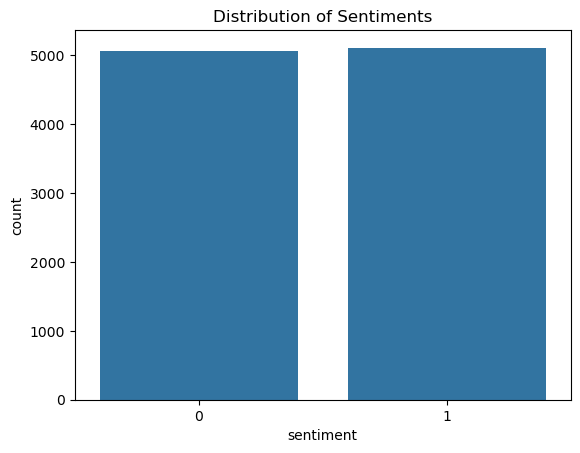

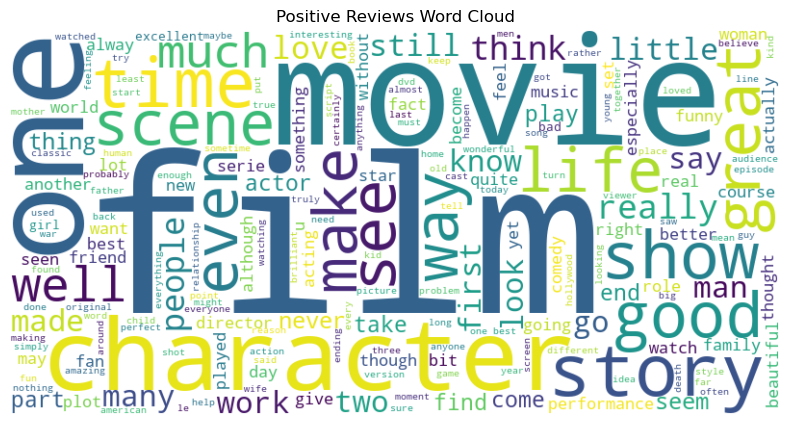

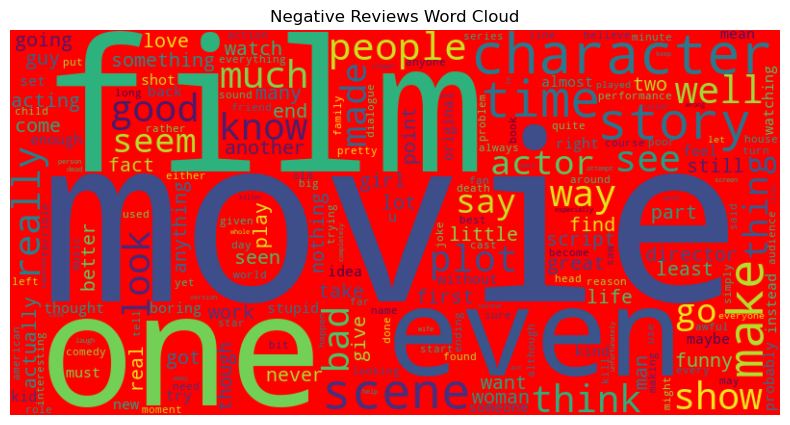

In [9]:
# Plotting the distribution of sentiments
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.show()

# Generating word clouds
positive_reviews = df[df['sentiment'] == 1]['cleaned_reviews']
negative_reviews = df[df['sentiment'] == 0]['cleaned_reviews']

positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='red').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()


# Multiple Machine Learning Model Training

In [4]:
# Train multiple models
models = {
    'Logistic Regression': LogisticRegression(),
    'Naive Bayes': MultinomialNB(),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(X_train_vect, y_train)
    y_pred = model.predict(X_test_vect)
    y_pred_proba = model.predict_proba(X_test_vect)[:, 1]
    print(f'Model: {name}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'ROC-AUC: {roc_auc_score(y_test, y_pred_proba)}')
    print(classification_report(y_test, y_pred))
    print('\n')



Model: Logistic Regression
Accuracy: 0.8790560471976401
ROC-AUC: 0.949568765470297
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1010
           1       0.86      0.91      0.88      1024

    accuracy                           0.88      2034
   macro avg       0.88      0.88      0.88      2034
weighted avg       0.88      0.88      0.88      2034



Model: Naive Bayes
Accuracy: 0.8495575221238938
ROC-AUC: 0.9334255105198019
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1010
           1       0.84      0.87      0.85      1024

    accuracy                           0.85      2034
   macro avg       0.85      0.85      0.85      2034
weighted avg       0.85      0.85      0.85      2034



Model: Support Vector Machine
Accuracy: 0.8810226155358899
ROC-AUC: 0.950811223700495
              precision    recall  f1-score   support

           0       0.90      0.85      0.8

# Hyperparameters for the Models

In [5]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train_vect, y_train)

print('Best parameters found:', grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_vect)
y_pred_proba = best_model.predict_proba(X_test_vect)[:, 1]

print(f'Best Random Forest Model Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Best Random Forest Model ROC-AUC: {roc_auc_score(y_test, y_pred_proba)}')
print(classification_report(y_test, y_pred))


Best parameters found: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 300}
Best Random Forest Model Accuracy: 0.8470993117010817
Best Random Forest Model ROC-AUC: 0.9344117419554455
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      1010
           1       0.84      0.87      0.85      1024

    accuracy                           0.85      2034
   macro avg       0.85      0.85      0.85      2034
weighted avg       0.85      0.85      0.85      2034



# flask deployment


In [1]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    review = request.json['review']
    cleaned_review = clean_text(review)
    review_vect = vectorizer.transform([cleaned_review])
    prediction = best_model.predict(review_vect)
    sentiment = 'positive' if prediction[0] == 1 else 'negative'
    return jsonify({'sentiment': sentiment})

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\saire\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
